In [1]:
import lightkurve as lk
import vetting as vt

from importlib import reload

In [2]:
# TESS example used in the paper, with a false positive TOI 360.01 
# https://iopscience.iop.org/article/10.3847/2515-5172/ac376a
tic, sector = 13023738, 2  # quite a few other sectors too
t0 = 1363.035
duration = 3.024 / 24
period = 8.057

In [3]:
download_dir = "../../data"

sr = lk.search_targetpixelfile(f"TIC {tic}", mission='TESS', sector=sector)
tpf = sr.download(download_dir=download_dir)
tpf

TessTargetPixelFile(TICID: 13023738)

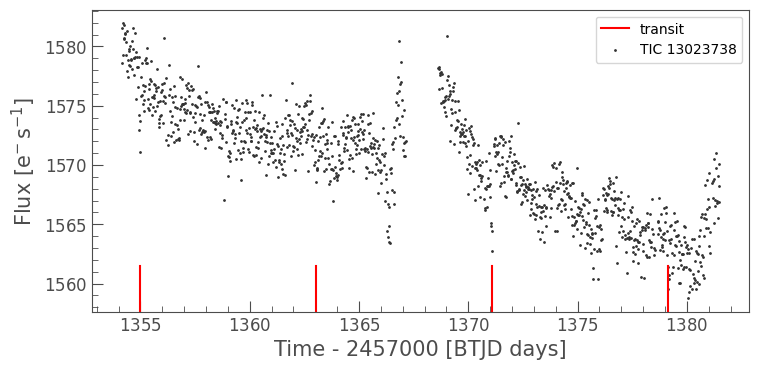

In [4]:
ax = tpf.to_lightcurve().remove_outliers(sigma=7).scatter();
ax.axvline(t0, c='red', ymax=0.15, label="transit");
ax.legend();
for i in [-1, 1, 2]:
    ax.axvline(t0 + i * period, c='red', ymax=0.15, label="transit");

([array([ True])],
 [(0.26559581892970097,)],
 [(4.506402460350039e-07,)],
 [(0.5311911872191558,)],
 dict_keys(['figs', 'pvalues', 'pvalues_x', 'pvalues_y', 'centroid_offset_detected', 'lc_list', 'tpf_m_list', 'diagnostics_figs']))

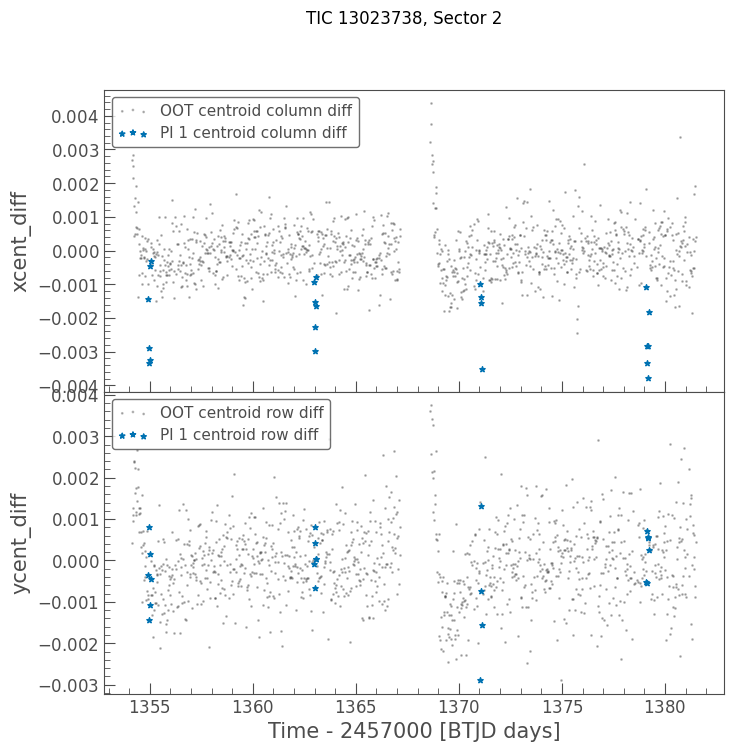

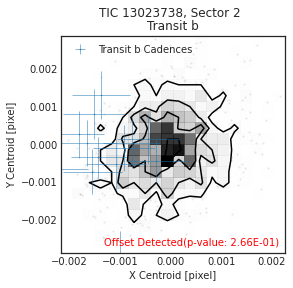

In [30]:
# reload(vt.centroiding)
# reload(vt)

# if p-value is < 0.05 (5%), it means signficant centroid offset
# - distribution of centroid outside dips are not from the same population of the centroid during dips
r = vt.centroid_test(tpf, period, t0, duration, aperture_mask='pipeline', 
#                      plot=False,
                     include_diagnostics=True,
                     nsamp=100,
#                      kernel=21,  # default is 21
#                   transit_depths=0.0036,
                 );
( 
    r['centroid_offset_detected'],
    r['pvalues'], 
    r['pvalues_x'],
    r['pvalues_y'],
    r.keys(), 
)

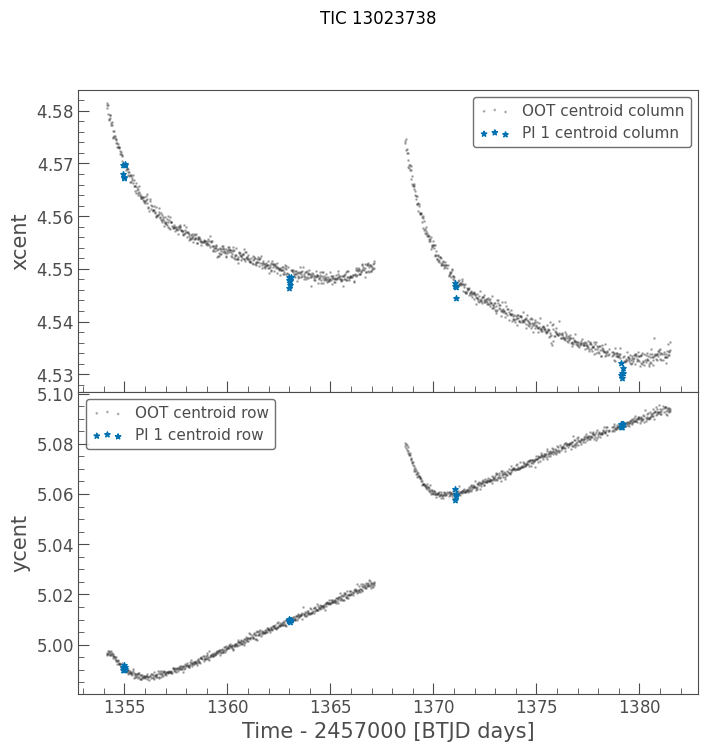

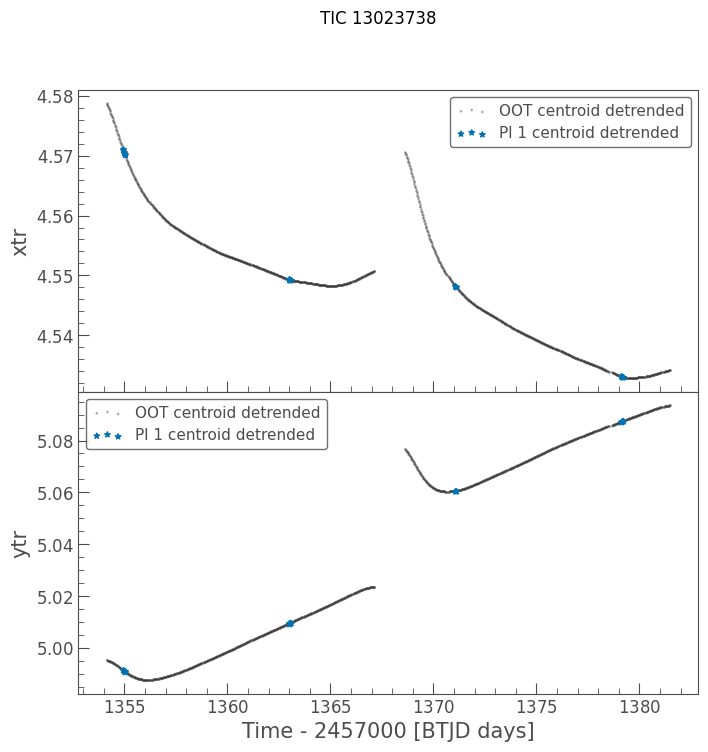

In [31]:
# reload(vt.centroiding)
# reload(vt)

# plot estimated centroids / detrended centroids to check if the detrending is over/under aggressive
lc = r['lc_list'][0]
fig1 = vt.centroiding.plot_centroids_vs_time(lc, "cent");
fig2 = vt.centroiding.plot_centroids_vs_time(lc, "tr");

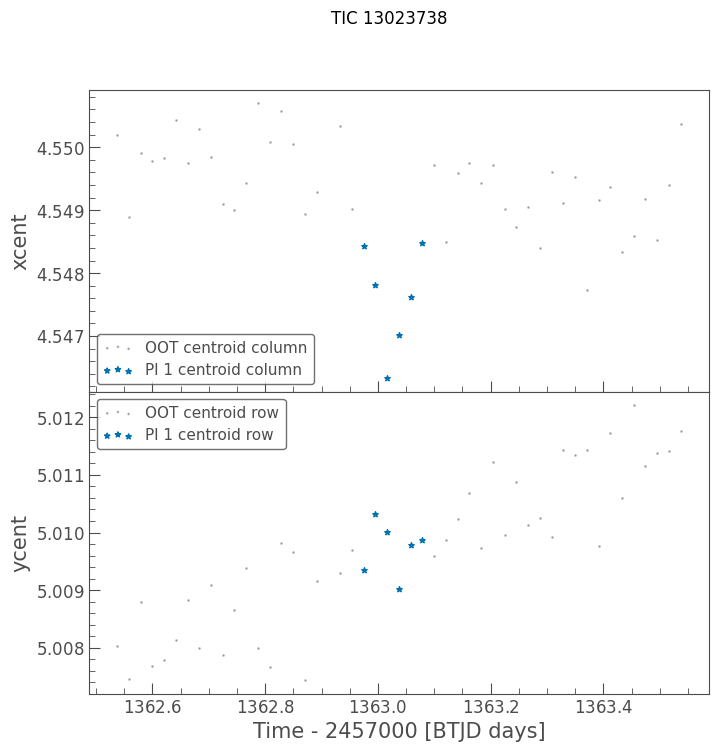

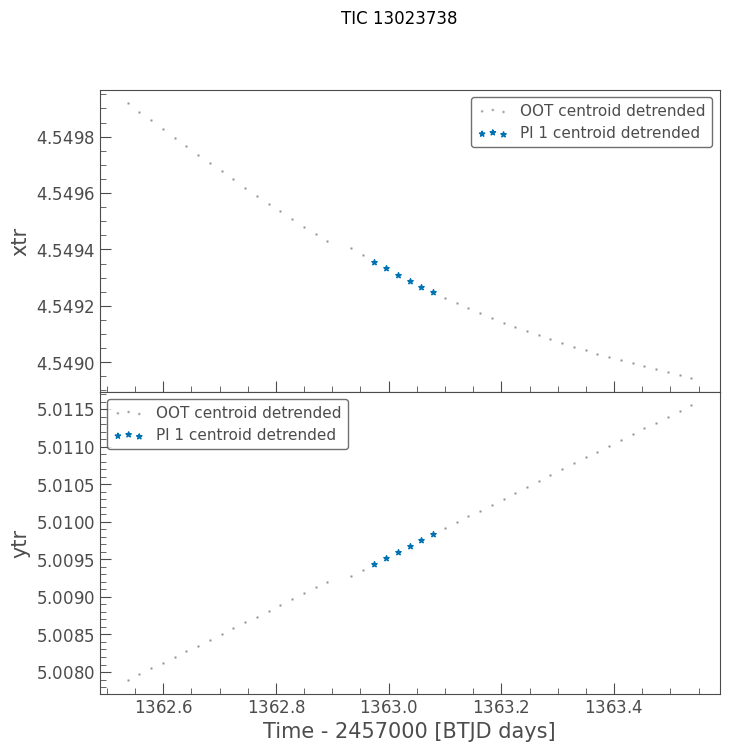

In [32]:
# zoom in to a dip to inspect again
lc_trunc = r['lc_list'][0].truncate(t0 - duration * 4, t0 + duration * 4)
fig1 = vt.centroiding.plot_centroids_vs_time(lc_trunc, "cent");
fig2 = vt.centroiding.plot_centroids_vs_time(lc_trunc, "tr");

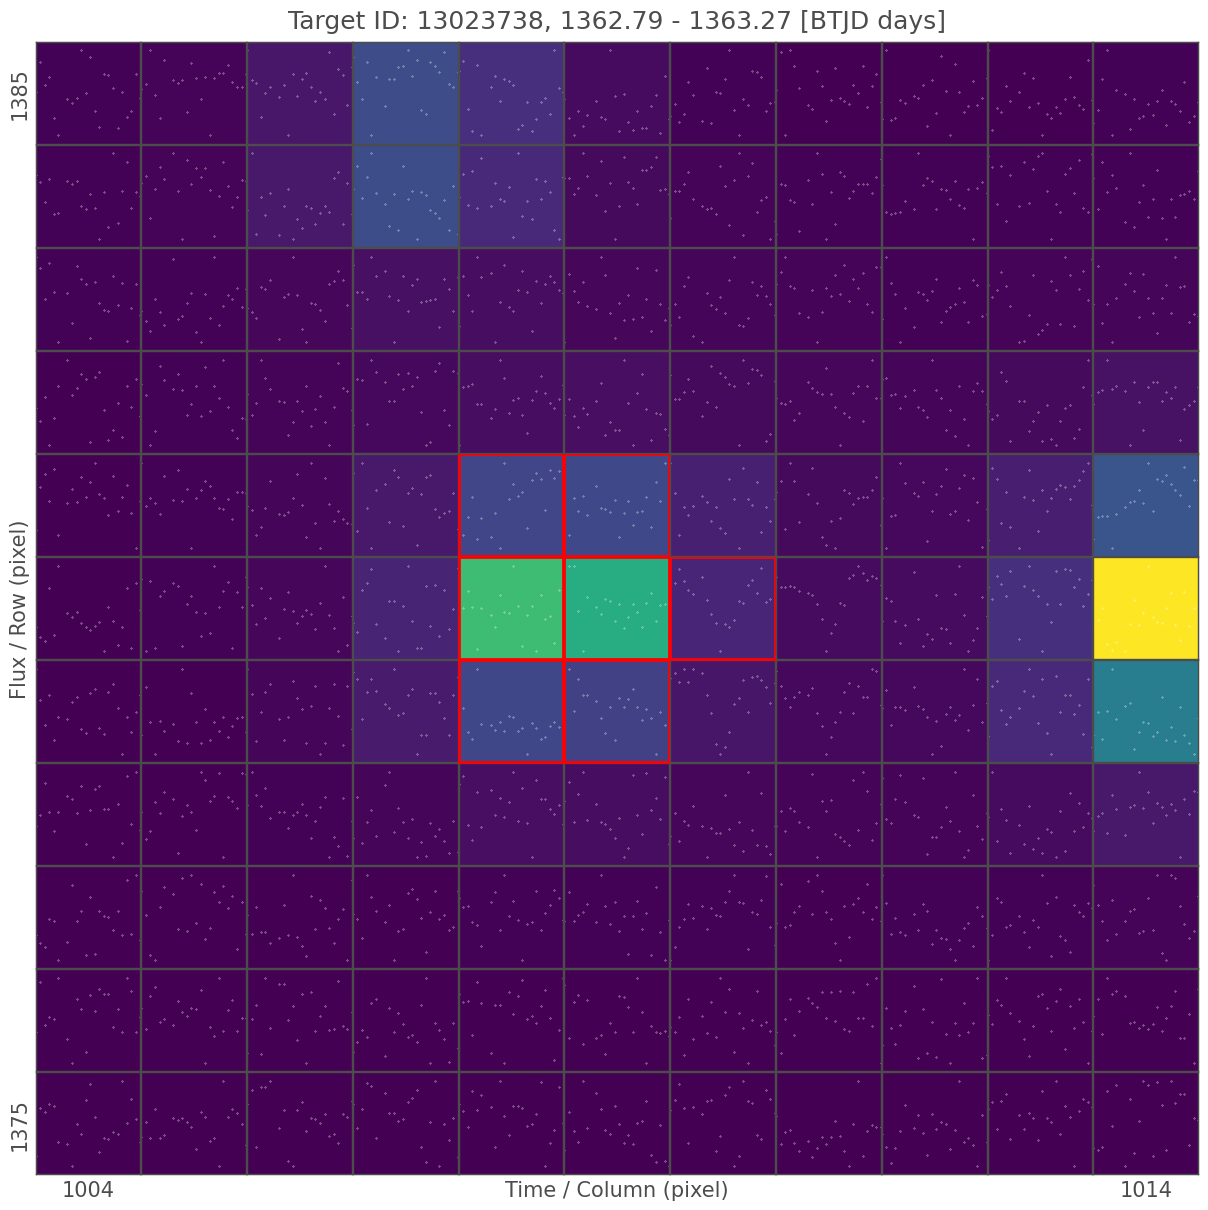

In [33]:
# Per pixel plot of a dip
tpf_trunc = tpf[(t0 - (duration/2) * 4 < tpf.time.value) & (tpf.time.value < t0 + (duration/2) * 4)]
# tpf_trunc.to_lightcurve().remove_outliers(sigma=7).normalize().scatter();
ax = tpf_trunc.plot_pixels(aperture_mask="pipeline", show_flux=True);

#### Miscellanesous trials

92

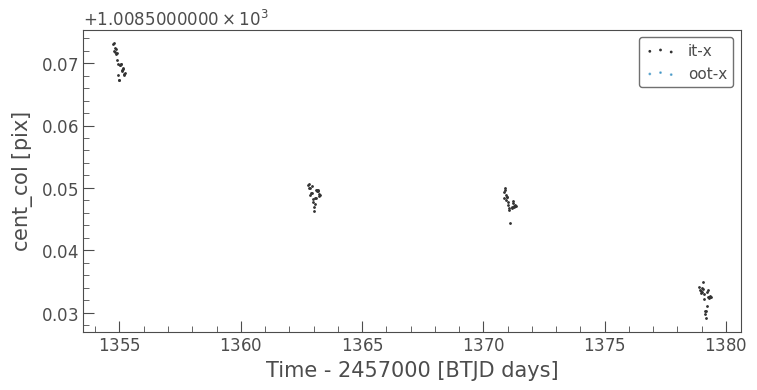

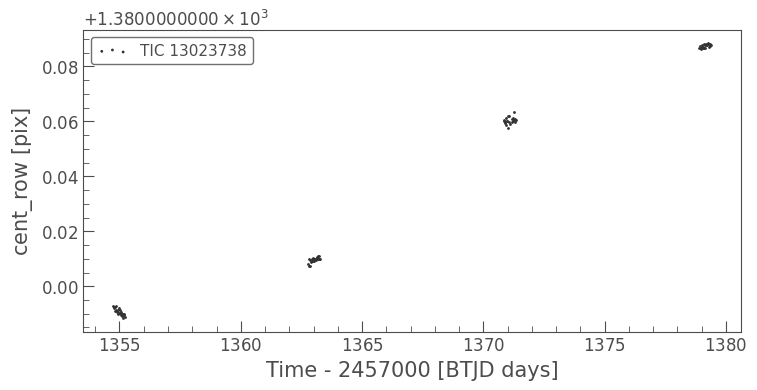

In [84]:
# try to do t-test myself
from astropy.convolution import Gaussian1DKernel, convolve
import numpy as np
from scipy.stats import ttest_ind

# def smooth_centroid(time, xcent, ycent, kernel=21):
#     dt = np.diff(time.jd)
#     breaks = np.where(dt > 10 * np.median(dt))[0] + 1
#     ms = [
#         np.in1d(np.arange(len(time)), i)
#         for i in np.array_split(np.arange(len(time)), breaks)
#     ]
#     xtr, ytr = [], []
#     for m in ms:
#         print('dbg', m)
#         xtr.append(
#             convolve(xcent[m], Gaussian1DKernel(kernel), boundary="extend")
#         )
#         ytr.append(
#             convolve(ycent[m], Gaussian1DKernel(kernel), boundary="extend")
#         )
#     return xtr, ytr
        
    
cent_col, cent_row = tpf.estimate_centroids(
#     method="quadratic"
);

# cent_s_col, cent_s_row = smooth_centroid(tpf.time, cent_col, cent_row)


lc = tpf.to_lightcurve()
lc['cent_col'] = cent_col
lc['cent_row'] = cent_row

# only use data point around dips
truncate_mask = lc.create_transit_mask(period, t0, duration * 4)
lc = lc[truncate_mask]

tmask = lc.create_transit_mask(period, t0, duration * 4)
ax_col = lc[tmask].scatter(column="cent_col", s=4, label="it-x");
ax_col = lc[~tmask].scatter(ax=ax_col, column="cent_col", alpha=0.5, label="oot-x");
ax_row = lc.scatter(column="cent_row");


ttest_ind(lc['cent_col'][tmask], lc['cent_col'][~tmask])

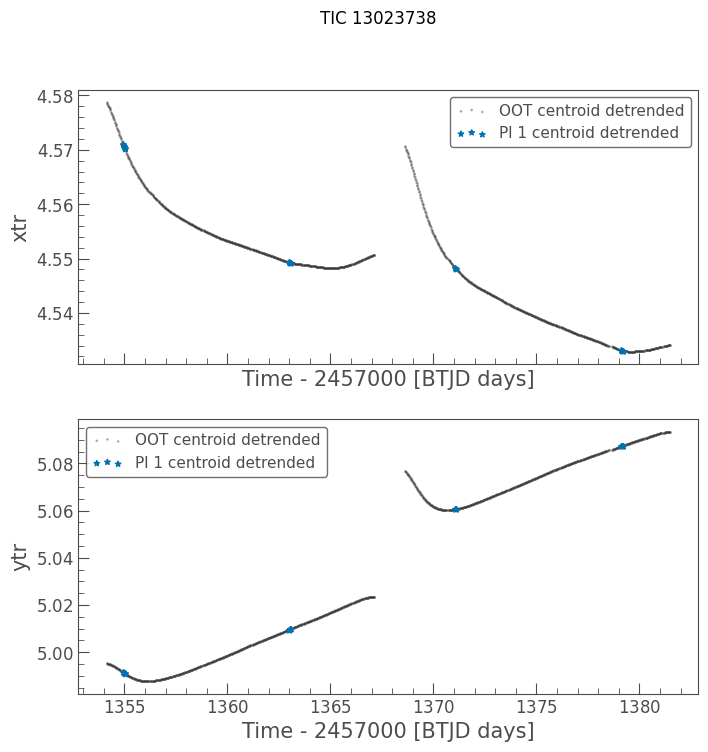

In [117]:
reload(vt.centroiding)
fig = vt.centroiding.plot_centroids_vs_time(r['lc_list'][0], r['tmasks_list'][0], "tr");

In [125]:
lc = r['lc_list'][0]
lc.xsamps[0]

array([0.0025797 , 0.00226177, 0.0028252 , ..., 0.00015028, 0.00104612,
       0.00070434])

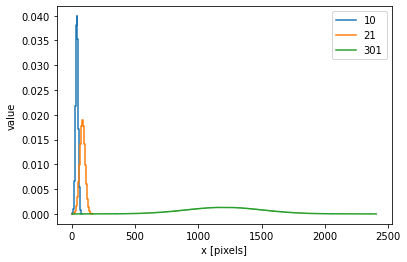

In [124]:
import matplotlib.pyplot as plt
from astropy.convolution import Gaussian1DKernel
gauss_1D_kernel = Gaussian1DKernel(10)
plt.plot(gauss_1D_kernel, drawstyle='steps', label="10")
plt.xlabel('x [pixels]')
plt.ylabel('value')

gauss_1D_kernel = Gaussian1DKernel(21)
plt.plot(gauss_1D_kernel, drawstyle='steps', label="21")

gauss_1D_kernel = Gaussian1DKernel(301)
plt.plot(gauss_1D_kernel, drawstyle='steps', label="301")

plt.legend()

plt.show()

In [81]:
from scipy.stats import ttest_ind

(
    ttest_ind(lc.xcent_diff[oot_mask], lc.xcent_diff[~oot_mask], equal_var=False).pvalue, 
    ttest_ind(lc.xcent_diff[oot_mask], lc.ycent_diff[~oot_mask], equal_var=False).pvalue, 
)


(1.2889629808948184e-08, 0.4090606829182727)